In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline


### Functions used to summaries results:

In [3]:
def accuracy(model, y_test, x_test):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    if model.__class__.__name__ == 'RegressionResultsWrapper':
        print('Multi linear regression\n----------')
    
    else:
        print('Lasso regression')
        
    
    print(f'Mean Squared Error: {round(mse,2)} \nMean Absolute Percentage Error: {round(mape*100,2)}%')

In [4]:
df = pd.read_csv('insurance_dataset.csv')
df

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,male,46.67,2,no,northeast,High blood pressure,None,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,None,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728


## Medical insurance charges
- **Age**: The age of the insured individual.
- **Gender**: The gender of the insured individual.
- **BMI** (Body Mass Index): A measure of body fat based on height and weight.
- **Children**: The number of children covered by the insurance plan.
- **Smoking Status**: Indicates whether the individual is a smoker.
- **Region**: The geographical region of the insured individual.
- **Medical History**: Information about the individual's old medical problems.
- **Family Medical History**: Information about the family's medical record.
- **Exercise Frequency**: The frequency of the individual's exercise routine.
- **Occupation**: The occupation of the insured individual.
- **Coverage Level**: The type of insurance plan.
- **Charges**: The health insurance charges for the individual

Data is from Kaggle: https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning/data



## Possible questions:

1. Insurance industry today is full of data on their customers. What we aim to do is to figure out if an insurance company can leverage this data to automate decissions. We will look at whether there is machine learning models that can accuratly set the "coverage_level" of a customer, and if a model can, with good accuracy, set a "charge" to a customer. 

- TSNE to convert data to 2D plane and use clustering to predict future data points "coverage_level".

- Some regression to predict charge.

- Discuss whether the accuracy is good enough for this model to be used by a company. Are there ethical problems with this? Like is it a problem that the model can set higher charges at times due to predictions being somehwat unaccurate. Should we use some regression type, like ridge, to lower the predictions such that this ethical issue is minimized. This could be justified by the savings the company gets from automizing the process.

- Is it ethical to use familiy records to set price

- Se lovverket hva som er lov å diskriminere mot

In [137]:
df # Should we add a constant term?

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,male,46.67,2,no,northeast,High blood pressure,None,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,None,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728


## Regressions

In [5]:
# Divide into dependent and independent vairables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.30)
X_train['charges'] = y_train
training = X_train.copy()

In [225]:
# Good way to code regression with categorical variables
formula = 'charges ~ age + C(gender) + bmi + children + C(smoker) + C(region) + C(medical_history) + C(family_medical_history) + C(exercise_frequency) + C(occupation) + C(coverage_level)'
model = smf.ols(formula = formula, data = training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.424e+06
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:58:23   Log-Likelihood:            -4.9584e+06
No. Observations:              700000   AIC:                         9.917e+06
Df Residuals:                  699977   BIC:                         9.917e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          1.05e+04      2.305   4553.765      0.000    1.05e+04    1.05e+04
C(gender)[T.male]                                  999.1025      0.690   1449.014      0.000     997.751    1000.454
C(smoker)[T.yes]                                  5000.5125      0.690   7252.240      0.000    4999.161    5001.864
C(region)[T.northwest]                            -699.8829      0.975   -717.831      0.000    -701.794    -697.972
C(region)[T.southeast]                            -498.2216      0.975   -510.829      0.000    -500.133    -496.310
C(region)[T.southwest]                            -799.1929      0.974   -820.270      0.000    -801.103    -797.283
C(medical_history)[T.Heart disease]               3000.9656      0.975   3077.650      0.000    2999.054    3002.877
C(medical_history)[T.High blood pressure]        -1001.6183      0.976  -1025.955      0.000   -1003.532    -999.705
C(medical_history)[T.None]                       -2000.0484      0.975  -2051.038      0.000   -2001.960   -1998.137
C(family_medical_history)[T.Heart disease]        3001.5406      0.976   3075.926      0.000    2999.628    3003.453
C(family_medical_history)[T.High blood pressure]  -999.1043      0.975  -1024.282      0.000   -1001.016    -997.193
C(family_medical_history)[T.None]                -1998.8432      0.975  -2050.254      0.000   -2000.754   -1996.932
C(exercise_frequency)[T.Never]                   -1999.6565      0.976  -2049.010      0.000   -2001.569   -1997.744
C(exercise_frequency)[T.Occasionally]             -997.0437      0.975  -1022.931      0.000    -998.954    -995.133
C(exercise_frequency)[T.Rarely]                  -1499.4402      0.975  -1538.238      0.000   -1501.351   -1497.530
C(occupation)[T.Student]                          -998.2478      0.975  -1023.893      0.000   -1000.159    -996.337
C(occupation)[T.Unemployed]                      -1498.7028      0.974  -1537.925      0.000   -1500.613   -1496.793
C(occupation)[T.White collar]                      502.2970      0.976    514.764      0.000     500.385     504.210
C(coverage_level)[T.Premium]                      5000.0282      0.845   5917.936      0.000    4998.372    5001.684
C(coverage_level)[T.Standard]                     1999.8298      0.844   2368.999      0.000    1998.175    2001.484
age                                                 19.9844      0.025    803.237      0.000      19.936      20.033
bmi                                                 49.9894      0.037   1338.260      0.000      49.916      50.063
children                                           200.3005      0.202    992.092      0.000     199.905     200.696
=========================================

In [226]:
accuracy(model, y_test, X_test)

Multi linear regression
Mean Squared Error: 83738.87 
Mean Absolute Percentage Error: 1.62%


## Regularization with Lasso

In [6]:
lasso_df = pd.get_dummies(df) # Important for preparing the data for Lasso regression

X_lasso = lasso_df.drop('charges', axis = 1)
y_lasso = lasso_df.iloc[:, 3]

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lasso,y_lasso, test_size= 0.30)


#### Using AIC to determine the alpha hyperparameter for Lasso regression

In [ ]:
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion='aic')).fit(X_train_l, y_train_l)

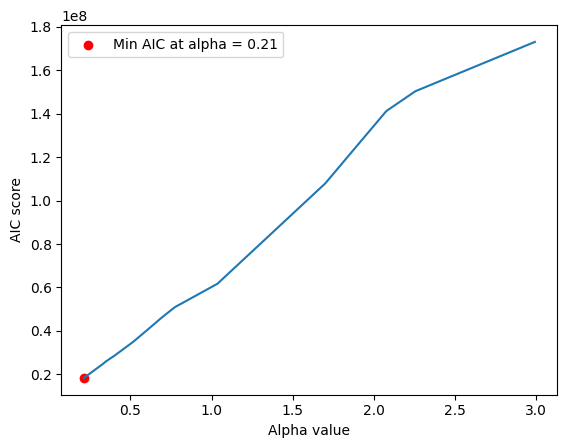

In [253]:
results = pd.DataFrame({
    'alphas': lasso_lars_ic[-1].alphas_,
    'aic criterion': lasso_lars_ic[-1].criterion_,
})

plt.plot(results['alphas'], results['aic criterion'])
plt.xlabel('Alpha value')
plt.ylabel('AIC score')
min_aic = results.min().tolist()
plt.scatter(min_aic[0], min_aic[1], c = 'red', label = f'Min AIC at alpha = {round(min_aic[0],2)}')

plt.legend()
plt.show()

- The LassoLarsIC API stops at that point because it estimates that it is converging. Continuing would introduce numerical errors higher than the remaining correlation according to sklearn documentation. 

In [15]:
clf = Lasso(alpha=0.21, fit_intercept=True, max_iter=10000)
clf.fit(X_train_l, y_train_l)

Lasso(alpha=0.21, max_iter=10000)

In [14]:
accuracy(clf, y_test_l, X_test_l)

Lasso regression
Mean Squared Error: 83613.13 
Mean Absolute Percentage Error: 1.62%


#### Interpretation

Seems Lasso yields little improvement from the basic OLS model. This is of no suprise as on the summary for the OLS model it seemed to strongly indicate that all variables are important. Since Lasso is a linear regression with a penalty term that helps to prevent overfitting and facilitate automatic feature selection, it is not suprising that it did not yield uch improvements as all features in the dataset are important. Thus, for simplicity, we continue with the OLS.